In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import mannwhitneyu

In [2]:
df = pd.read_feather("../output/paper_submission/fig2_data_prop_reads.feather")
cols = df.columns.values
cols[-1] = "values"
df.columns = cols
df["log10_values"] = np.log10(df["values"])
df["log2_values"] = np.log2(df["values"])

# Adult Bulk

In [3]:
adult_bulk = (
    df.query("stage == 'adult' & data_source == 'RNA-Seq'")
    .drop("stage,data_source,cell_type".split(","), axis=1)
)

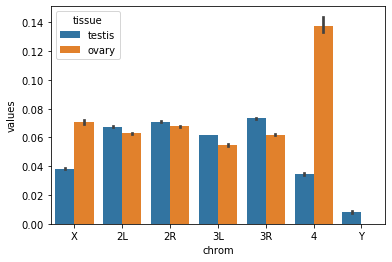

In [4]:
sns.barplot(
    x="chrom", 
    y="values", 
    order="X,2L,2R,3L,3R,4,Y".split(","),
    hue="tissue",
    hue_order=["testis", "ovary"],
    data=adult_bulk)

## Data are not normal and have heteroschedasticity of variance

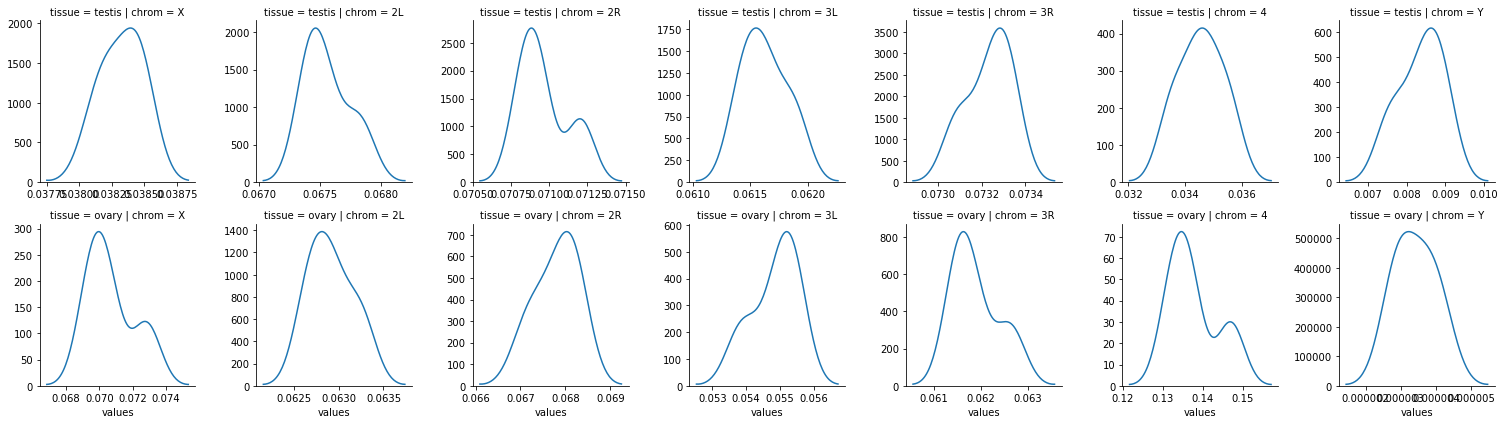

In [5]:
g = sns.FacetGrid(
    adult_bulk, 
    col="chrom", 
    row="tissue", 
    col_order="X,2L,2R,3L,3R,4,Y".split(","),
    row_order=["testis", "ovary"],
    sharex=False, 
    sharey=False
)
g.map(sns.kdeplot, "values")

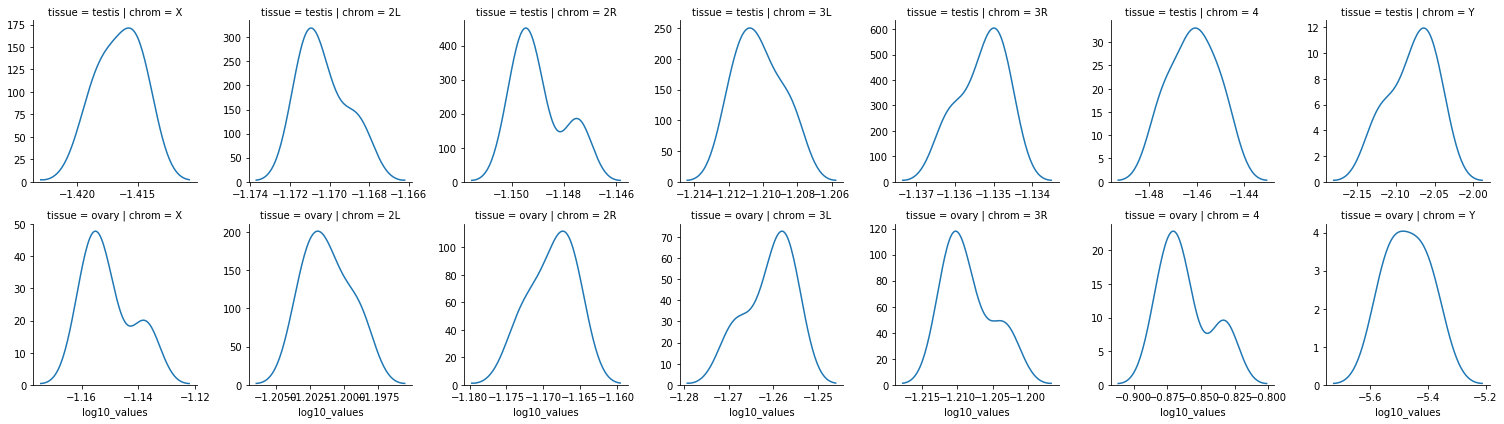

In [6]:
g = sns.FacetGrid(
    adult_bulk, 
    col="chrom", 
    row="tissue", 
    col_order="X,2L,2R,3L,3R,4,Y".split(","),
    row_order=["testis", "ovary"],
    sharex=False, 
    sharey=False
)
g.map(sns.kdeplot, "log10_values")

There are normality issues.

In [7]:
adult_bulk.groupby("chrom")["values"].agg(["mean", "std", "sem"])

,mean,std,sem
chrom,,,
2L,0.065238,0.002490,0.000880
2R,0.069381,0.001725,0.000610
3L,0.058237,0.003650,0.001291
3R,0.067559,0.006075,0.002148
4,0.086124,0.055302,0.019552
X,0.054508,0.017330,0.006127
Y,0.004184,0.004486,0.001586


In [8]:
adult_bulk.groupby("tissue")["values"].agg(["mean", "std", "sem"])

,mean,std,sem
tissue,,,
ovary,0.06512,0.037911,0.007165
testis,0.05066,0.022865,0.004321


In [9]:
adult_bulk.groupby(["chrom", "tissue"])["values"].agg(["mean", "std", "sem"])

mean           std           sem
chrom tissue                                      
2L    ovary   0.062918  2.571107e-04  1.285554e-04
      testis  0.067559  1.925366e-04  9.626829e-05
2R    ovary   0.067798  4.806978e-04  2.403489e-04
      testis  0.070964  1.716298e-04  8.581491e-05
3L    ovary   0.054852  6.941742e-04  3.470871e-04
      testis  0.061623  2.017072e-04  1.008536e-04
3R    ovary   0.061886  5.177013e-04  2.588507e-04
      testis  0.073232  1.058381e-04  5.291903e-05
4     ovary   0.137694  6.604872e-03  3.302436e-03
      testis  0.034555  8.383219e-04  4.191609e-04
X     ovary   0.070691  1.535257e-03  7.676285e-04
      testis  0.038326  1.583369e-04  7.916846e-05
Y     ovary   0.000003  5.857253e-07  2.928626e-07
      testis  0.008364  5.930816e-04  2.965408e-04

There looks to be some differences in variance. ANOVA may not be appropriate.

## ANOVA fails assumptions

In [10]:
formula = "values ~ C(tissue)*C(chrom)"
model = ols(formula, adult_bulk).fit()
summary = model.summary()
display(summary.tables[0])
summary.tables[2]

Dep. Variable:,values,R-squared:,0.997
Model:,OLS,Adj. R-squared:,0.997
Method:,Least Squares,F-statistic:,1244.
Date:,"Thu, 19 Dec 2019",Prob (F-statistic):,6.72e-50
Time:,18:07:31,Log-Likelihood:,280.80
No. Observations:,56,AIC:,-533.6
Df Residuals:,42,BIC:,-505.2
Df Model:,13,,
Covariance Type:,nonrobust,,


Omnibus:,63.252,Durbin-Watson:,1.705
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1075.340
Skew:,2.531,Prob(JB):,3.11e-234
Kurtosis:,23.862,Cond. No.,20.6


Overall model is significant, but there are violations of normality P(JB) and homoscedasticity of varnace P(Omnibus). But multi-colinearity looks ok.

In [11]:
formula = "log10_values ~ C(tissue)*C(chrom)"
model = ols(formula, adult_bulk).fit()
summary = model.summary()
display(summary.tables[0])
summary.tables[2]

Dep. Variable:,log10_values,R-squared:,1.000
Model:,OLS,Adj. R-squared:,1.000
Method:,Least Squares,F-statistic:,1.039e+04
Date:,"Thu, 19 Dec 2019",Prob (F-statistic):,3.15e-69
Time:,18:07:31,Log-Likelihood:,140.61
No. Observations:,56,AIC:,-253.2
Df Residuals:,42,BIC:,-224.9
Df Model:,13,,
Covariance Type:,nonrobust,,


Omnibus:,21.960,Durbin-Watson:,2.066
Prob(Omnibus):,0.000,Jarque-Bera (JB):,212.516
Skew:,0.122,Prob(JB):,7.13e-47
Kurtosis:,12.540,Cond. No.,20.6


Log does not help.

## Permutation test only 4th significant

In [12]:
def test(df):
    return np.abs(
        df.query("tissue == 'testis'")["values"].mean() -
        df.query("tissue == 'ovary'")["values"].mean()
    )

def test_permute(df):
    _df = df.copy()
    _df["values"] = _df["values"].sample(frac=1).values
    return _df.groupby("chrom").apply(test)

In [13]:
obs = adult_bulk.groupby("chrom").apply(test)
res = pd.concat((
    test_permute(adult_bulk)
    for _ in range(10_000)
), axis=1).T

In [14]:
(res >= obs).mean()

chrom
2L    0.8411
2R    0.8841
3L    0.7604
3R    0.6155
4     0.0000
X     0.1541
Y     0.7108
dtype: float64

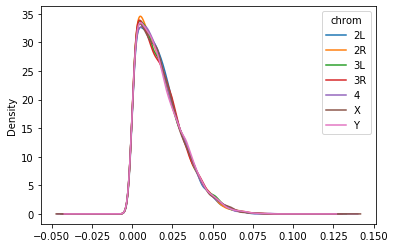

In [15]:
res.plot.kde()

## Pairwise Mann-Whitney 

In [16]:
def run_mann(x):
    testis = x.query("tissue == 'testis'")["values"].values
    ovary = x.query("tissue == 'ovary'")["values"].values
    return mannwhitneyu(testis, ovary, alternative="two-sided")

In [17]:
adult_bulk.groupby("chrom").apply(run_mann)

chrom
2L    (16.0, 0.03038282197657749)
2R    (16.0, 0.03038282197657749)
3L    (16.0, 0.03038282197657749)
3R    (16.0, 0.03038282197657749)
4      (0.0, 0.03038282197657749)
X      (0.0, 0.03038282197657749)
Y     (16.0, 0.03038282197657749)
dtype: object

## Log Fold Change

In [18]:
def run_lfc(x):
    testis = x.query("tissue == 'testis'")["values"].values
    ovary = x.query("tissue == 'ovary'")["values"].values
    return np.log2(testis.mean()/ovary.mean())

In [19]:
adult_bulk.groupby("chrom").apply(run_lfc)

chrom
2L     0.102694
2R     0.065828
3L     0.167945
3R     0.242873
4     -1.994519
X     -0.883223
Y     11.257936
dtype: float64

# Larval Bulk

In [20]:
larval_bulk = (
    df.query("stage == 'L3' & data_source == 'RNA-Seq'")
    .drop("stage,data_source,cell_type".split(","), axis=1)
)

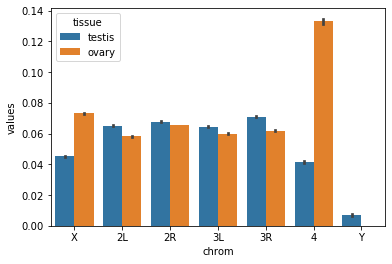

In [21]:
sns.barplot(
    x="chrom", 
    y="values", 
    order="X,2L,2R,3L,3R,4,Y".split(","),
    hue="tissue",
    hue_order=["testis", "ovary"],
    data=larval_bulk)

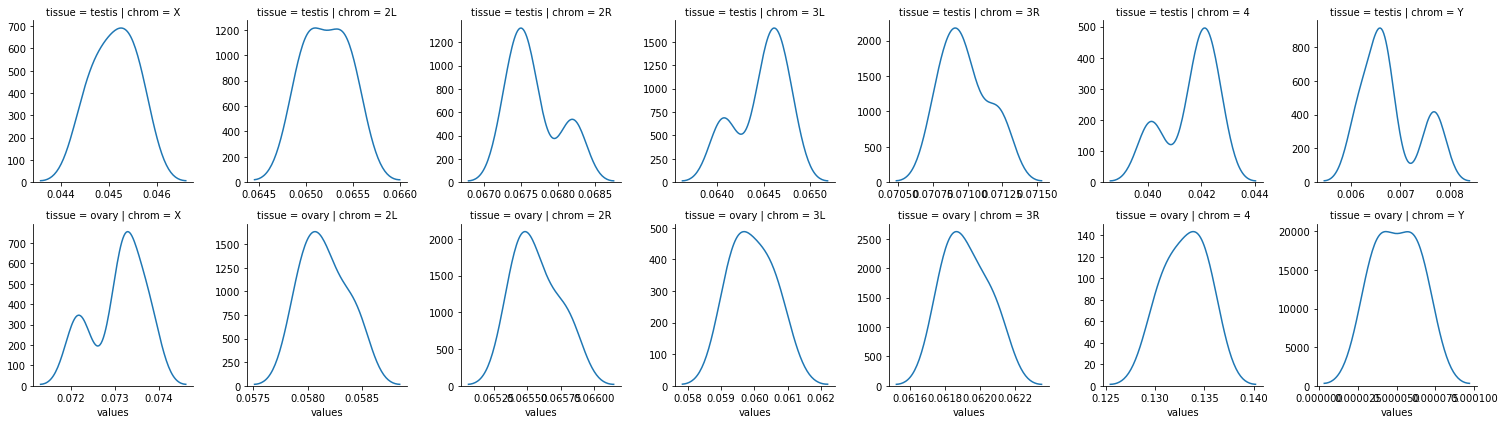

In [22]:
g = sns.FacetGrid(
    larval_bulk, 
    col="chrom", 
    row="tissue", 
    col_order="X,2L,2R,3L,3R,4,Y".split(","),
    row_order=["testis", "ovary"],
    sharex=False, 
    sharey=False
)
g.map(sns.kdeplot, "values")

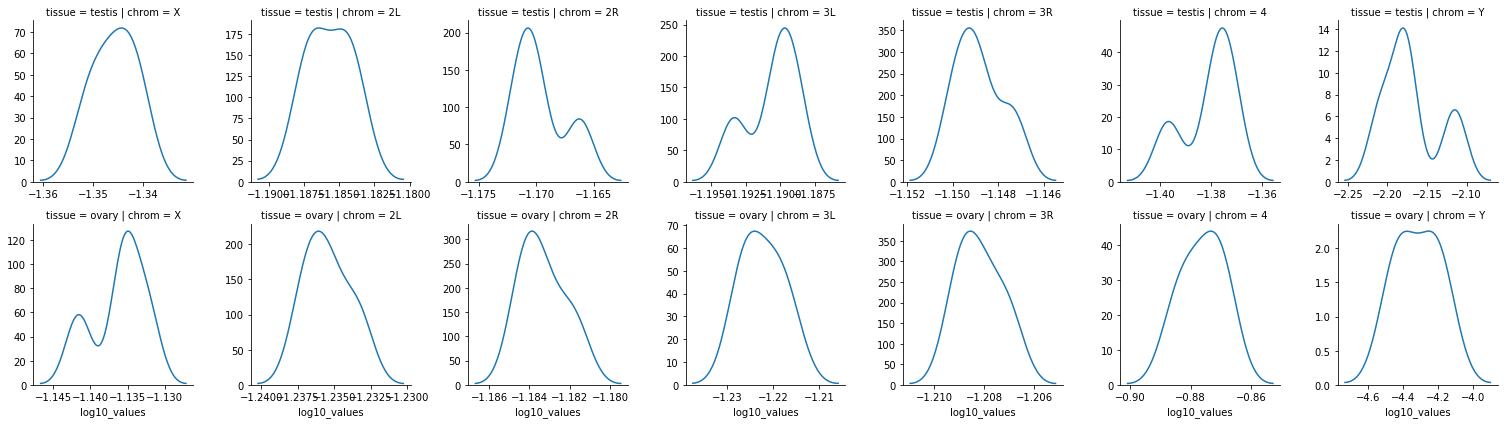

In [23]:
g = sns.FacetGrid(
    larval_bulk, 
    col="chrom", 
    row="tissue", 
    col_order="X,2L,2R,3L,3R,4,Y".split(","),
    row_order=["testis", "ovary"],
    sharex=False, 
    sharey=False
)
g.map(sns.kdeplot, "log10_values")

There are normality issues.

In [24]:
larval_bulk.groupby("chrom")["values"].agg(["mean", "std", "sem"])

,mean,std,sem
chrom,,,
2L,0.061682,0.003781,0.001337
2R,0.066619,0.001156,0.000409
3L,0.062210,0.002471,0.000874
3R,0.066451,0.004845,0.001713
4,0.087326,0.048884,0.017283
X,0.059102,0.014963,0.005290
Y,0.003417,0.003623,0.001281


In [25]:
larval_bulk.groupby("tissue")["values"].agg(["mean", "std", "sem"])

,mean,std,sem
tissue,,,
ovary,0.064535,0.036509,0.006900
testis,0.051696,0.021557,0.004074


In [26]:
larval_bulk.groupby(["chrom", "tissue"])["values"].agg(["mean", "std", "sem"])

mean       std       sem
chrom tissue                              
2L    ovary   0.058151  0.000218  0.000109
      testis  0.065214  0.000233  0.000117
2R    ovary   0.065567  0.000174  0.000087
      testis  0.067671  0.000374  0.000187
3L    ovary   0.059937  0.000625  0.000313
      testis  0.064482  0.000291  0.000146
3R    ovary   0.061921  0.000130  0.000065
      testis  0.070981  0.000181  0.000091
4     ovary   0.133029  0.002209  0.001104
      testis  0.041623  0.001047  0.000523
X     ovary   0.073090  0.000658  0.000329
      testis  0.045114  0.000468  0.000234
Y     ovary   0.000050  0.000014  0.000007
      testis  0.006784  0.000632  0.000316

There looks to be some differences in variance. ANOVA may not be appropriate.

In [27]:
formula = "values ~ C(tissue)*C(chrom)"
model = ols(formula, larval_bulk).fit()
summary = model.summary()
display(summary.tables[0])
summary.tables[2]

Dep. Variable:,values,R-squared:,1.000
Model:,OLS,Adj. R-squared:,0.999
Method:,Least Squares,F-statistic:,6996.
Date:,"Thu, 19 Dec 2019",Prob (F-statistic):,1.26e-65
Time:,18:11:09,Log-Likelihood:,331.72
No. Observations:,56,AIC:,-635.4
Df Residuals:,42,BIC:,-607.1
Df Model:,13,,
Covariance Type:,nonrobust,,


Omnibus:,20.266,Durbin-Watson:,1.735
Prob(Omnibus):,0.000,Jarque-Bera (JB):,97.508
Skew:,-0.592,Prob(JB):,6.70e-22
Kurtosis:,9.355,Cond. No.,20.6


Overall model is significant, but there are violations of normality P(JB) and homoscedasticity of varnace P(Omnibus). But multi-colinearity looks ok.

In [28]:
formula = "log10_values ~ C(tissue)*C(chrom)"
model = ols(formula, larval_bulk).fit()
summary = model.summary()
display(summary.tables[0])
summary.tables[2]

Dep. Variable:,log10_values,R-squared:,0.999
Model:,OLS,Adj. R-squared:,0.998
Method:,Least Squares,F-statistic:,2383.
Date:,"Thu, 19 Dec 2019",Prob (F-statistic):,8.17e-56
Time:,18:11:09,Log-Likelihood:,115.76
No. Observations:,56,AIC:,-203.5
Df Residuals:,42,BIC:,-175.2
Df Model:,13,,
Covariance Type:,nonrobust,,


Omnibus:,20.574,Durbin-Watson:,1.997
Prob(Omnibus):,0.000,Jarque-Bera (JB):,175.263
Skew:,0.055,Prob(JB):,8.75e-39
Kurtosis:,11.666,Cond. No.,20.6


Log does not help.

In [29]:
def test(df):
    return np.abs(
        df.query("tissue == 'testis'")["values"].mean() -
        df.query("tissue == 'ovary'")["values"].mean()
    )

def test_permute(df):
    _df = df.copy()
    _df["values"] = _df["values"].sample(frac=1).values
    return _df.groupby("chrom").apply(test)

In [30]:
obs = larval_bulk.groupby("chrom").apply(test)
res = pd.concat((
    test_permute(larval_bulk)
    for _ in range(10000)
), axis=1).T

In [31]:
(res >= obs).mean()

chrom
2L    0.7383
2R    0.9112
3L    0.8238
3R    0.6742
4     0.0001
X     0.1978
Y     0.7482
dtype: float64

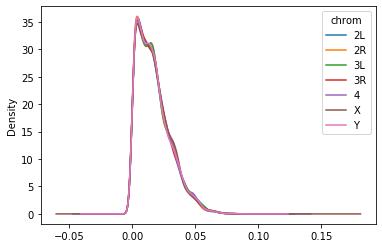

In [32]:
res.plot.kde()

## Pairwise Mann-Whitney 

In [33]:
def run_mann(x):
    testis = x.query("tissue == 'testis'")["values"].values
    ovary = x.query("tissue == 'ovary'")["values"].values
    return mannwhitneyu(testis, ovary, alternative="two-sided")

In [34]:
larval_bulk.groupby("chrom").apply(run_mann)

chrom
2L    (16.0, 0.03038282197657749)
2R    (16.0, 0.03038282197657749)
3L    (16.0, 0.03038282197657749)
3R    (16.0, 0.03038282197657749)
4      (0.0, 0.03038282197657749)
X      (0.0, 0.03038282197657749)
Y     (16.0, 0.03038282197657749)
dtype: object

## Log Fold Change

In [35]:
def run_lfc(x):
    testis = x.query("tissue == 'testis'")["values"].values
    ovary = x.query("tissue == 'ovary'")["values"].values
    return np.log2(testis.mean()/ovary.mean())

In [36]:
larval_bulk.groupby("chrom").apply(run_lfc)

chrom
2L    0.165375
2R    0.045563
3L    0.105443
3R    0.197018
4    -1.676273
X    -0.696085
Y     7.082768
dtype: float64

# Larval scRNA-Seq

In [37]:
larval_sc = (
    df.query("stage == 'L3' & data_source == 'scRNA-Seq' & cell_type != 'None'")
    .drop("stage,data_source,tissue".split(","), axis=1)
)

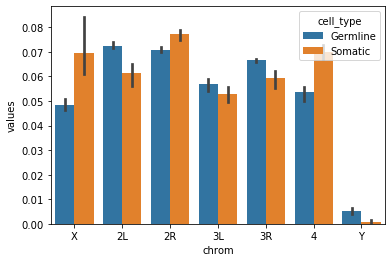

In [38]:
sns.barplot(
    x="chrom", 
    y="values", 
    order="X,2L,2R,3L,3R,4,Y".split(","),
    hue="cell_type",
    hue_order=["Germline", "Somatic"],
    data=larval_sc)

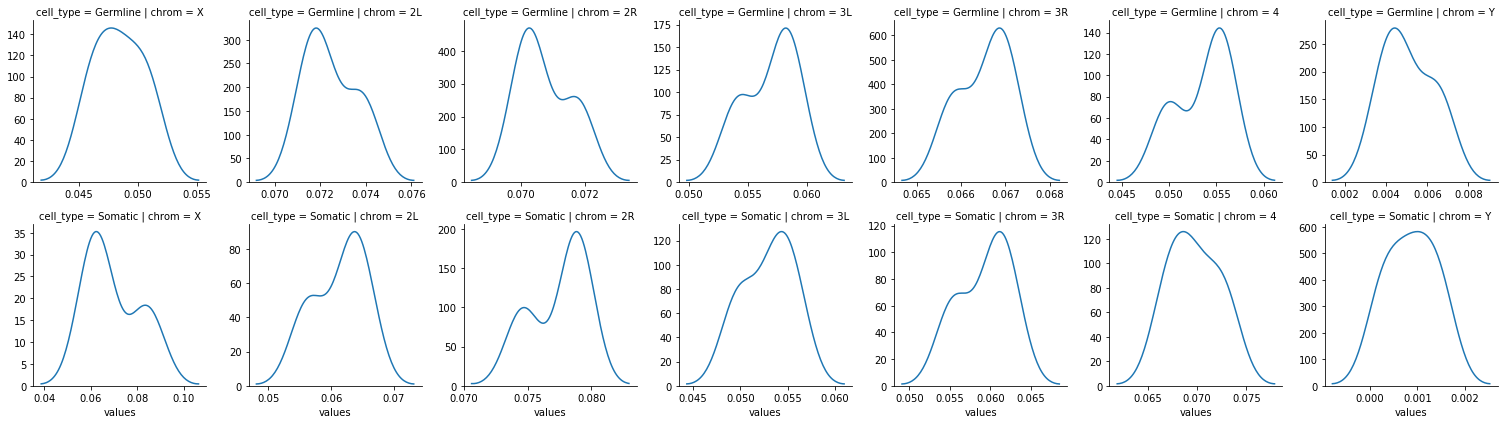

In [39]:
g = sns.FacetGrid(
    larval_sc, 
    col="chrom", 
    row="cell_type", 
    col_order="X,2L,2R,3L,3R,4,Y".split(","),
    row_order=["Germline", "Somatic"],
    sharex=False, 
    sharey=False
)
g.map(sns.kdeplot, "values")

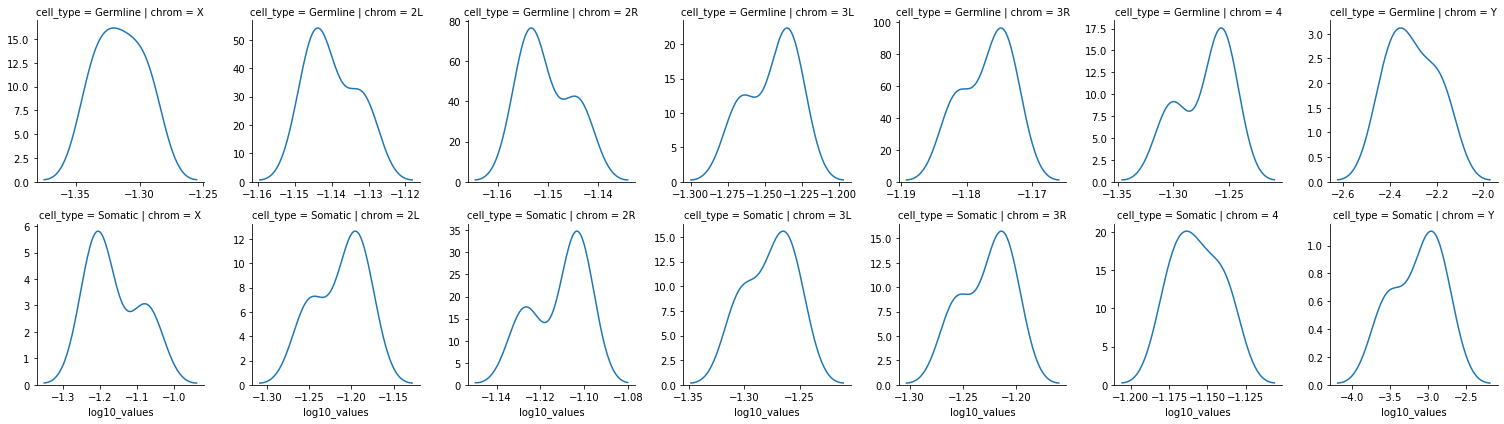

In [40]:
g = sns.FacetGrid(
    larval_sc, 
    col="chrom", 
    row="cell_type", 
    col_order="X,2L,2R,3L,3R,4,Y".split(","),
    row_order=["Germline", "Somatic"],
    sharex=False, 
    sharey=False
)
g.map(sns.kdeplot, "log10_values")

There are normality issues.

In [41]:
larval_sc.groupby("chrom")["values"].agg(["mean", "std", "sem"])

,mean,std,sem
chrom,,,
2L,0.066910,0.006775,0.002766
2R,0.074098,0.004018,0.001640
3L,0.054922,0.003243,0.001324
3R,0.062919,0.004544,0.001855
4,0.061649,0.009248,0.003776
X,0.059005,0.014221,0.005806
Y,0.002973,0.002479,0.001012


In [42]:
larval_sc.groupby("cell_type")["values"].agg(["mean", "std", "sem"])

,mean,std,sem
cell_type,,,
Germline,0.053388,0.022001,0.004801
Somatic,0.055891,0.024700,0.005390


In [43]:
larval_sc.groupby(["chrom", "cell_type"])["values"].agg(["mean", "std", "sem"])

mean       std       sem
chrom cell_type                              
2L    Germline   0.072472  0.001233  0.000712
      Somatic    0.061348  0.004517  0.002608
2R    Germline   0.070749  0.000902  0.000521
      Somatic    0.077448  0.002427  0.001401
3L    Germline   0.056910  0.002427  0.001401
      Somatic    0.052934  0.002923  0.001688
3R    Germline   0.066533  0.000634  0.000366
      Somatic    0.059305  0.003469  0.002003
4     Germline   0.053558  0.003131  0.001808
      Somatic    0.069739  0.002768  0.001598
X     Germline   0.048419  0.002304  0.001330
      Somatic    0.069591  0.012811  0.007396
Y     Germline   0.005073  0.001347  0.000777
      Somatic    0.000874  0.000572  0.000330

There looks to be some differences in variance. ANOVA may not be appropriate.

In [44]:
formula = "values ~ C(cell_type)*C(chrom)"
model = ols(formula, larval_sc).fit()
summary = model.summary()
display(summary.tables[0])
summary.tables[2]

Dep. Variable:,values,R-squared:,0.978
Model:,OLS,Adj. R-squared:,0.967
Method:,Least Squares,F-statistic:,94.51
Date:,"Thu, 19 Dec 2019",Prob (F-statistic):,1.43e-19
Time:,18:14:47,Log-Likelihood:,178.98
No. Observations:,42,AIC:,-330.0
Df Residuals:,28,BIC:,-305.6
Df Model:,13,,
Covariance Type:,nonrobust,,


Omnibus:,25.826,Durbin-Watson:,1.836
Prob(Omnibus):,0.000,Jarque-Bera (JB):,91.530
Skew:,1.268,Prob(JB):,1.33e-20
Kurtosis:,9.773,Cond. No.,20.6


Overall model is significant, but there are violations of normality P(JB) and homoscedasticity of varnace P(Omnibus). But multi-colinearity looks ok.

In [45]:
formula = "log10_values ~ C(cell_type)*C(chrom)"
model = ols(formula, larval_sc).fit()
summary = model.summary()
display(summary.tables[0])
summary.tables[2]

Dep. Variable:,log10_values,R-squared:,0.978
Model:,OLS,Adj. R-squared:,0.968
Method:,Least Squares,F-statistic:,94.97
Date:,"Thu, 19 Dec 2019",Prob (F-statistic):,1.34e-19
Time:,18:14:47,Log-Likelihood:,44.457
No. Observations:,42,AIC:,-60.91
Df Residuals:,28,BIC:,-36.59
Df Model:,13,,
Covariance Type:,nonrobust,,


Omnibus:,32.357,Durbin-Watson:,2.036
Prob(Omnibus):,0.000,Jarque-Bera (JB):,268.868
Skew:,-1.240,Prob(JB):,4.13e-59
Kurtosis:,15.144,Cond. No.,20.6


Log does not help.

In [46]:
def test(df):
    return np.abs(
        df.query("cell_type == 'Germline'")["values"].mean() -
        df.query("cell_type == 'Somatic'")["values"].mean()
    )

def test_permute(df):
    _df = df.copy()
    _df["values"] = _df["values"].sample(frac=1).values
    return _df.groupby("chrom").apply(test)

In [47]:
obs = larval_sc.groupby("chrom").apply(test)
res = pd.concat((
    test_permute(larval_sc)
    for _ in range(10000)
), axis=1).T

In [48]:
(res >= obs).mean()

chrom
2L    0.5418
2R    0.6960
3L    0.8156
3R    0.6774
4     0.4071
X     0.2679
Y     0.7956
dtype: float64

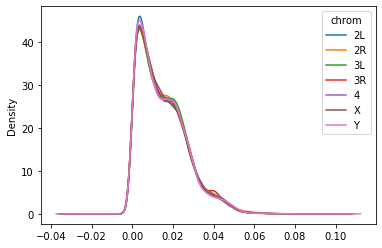

In [49]:
res.plot.kde()

## Pairwise Mann-Whitney 

In [50]:
def run_mann(x):
    germ = x.query("cell_type == 'Germline'")["values"].values
    soma = x.query("cell_type == 'Somatic'")["values"].values
    return mannwhitneyu(germ, soma, alternative="two-sided")

In [51]:
larval_sc.groupby("chrom").apply(run_mann)

chrom
2L    (9.0, 0.08085559837005224)
2R    (0.0, 0.08085559837005224)
3L    (8.0, 0.19043026382552397)
3R    (9.0, 0.08085559837005224)
4     (0.0, 0.08085559837005224)
X     (0.0, 0.08085559837005224)
Y     (9.0, 0.08085559837005224)
dtype: object

## Log Fold Change

In [52]:
def run_lfc(x):
    germ = x.query("cell_type == 'Germline'")["values"].values
    soma = x.query("cell_type == 'Somatic'")["values"].values
    return np.log2(germ.mean()/soma.mean())

In [53]:
larval_sc.groupby("chrom").apply(run_lfc)

chrom
2L    0.240415
2R   -0.130520
3L    0.104496
3R    0.165909
4    -0.380852
X    -0.523324
Y     2.536965
dtype: float64

# Transformations

In [54]:
from sklearn.preprocessing import quantile_transform, power_transform

In [55]:
larval_sc["quantile"] = quantile_transform(larval_sc["values"].values.reshape(-1, 1), output_distribution="normal", n_quantiles=20, copy=True).squeeze()
larval_sc["power"] = power_transform(larval_sc["values"].values.reshape(-1, 1), method="box-cox", copy=True).squeeze()

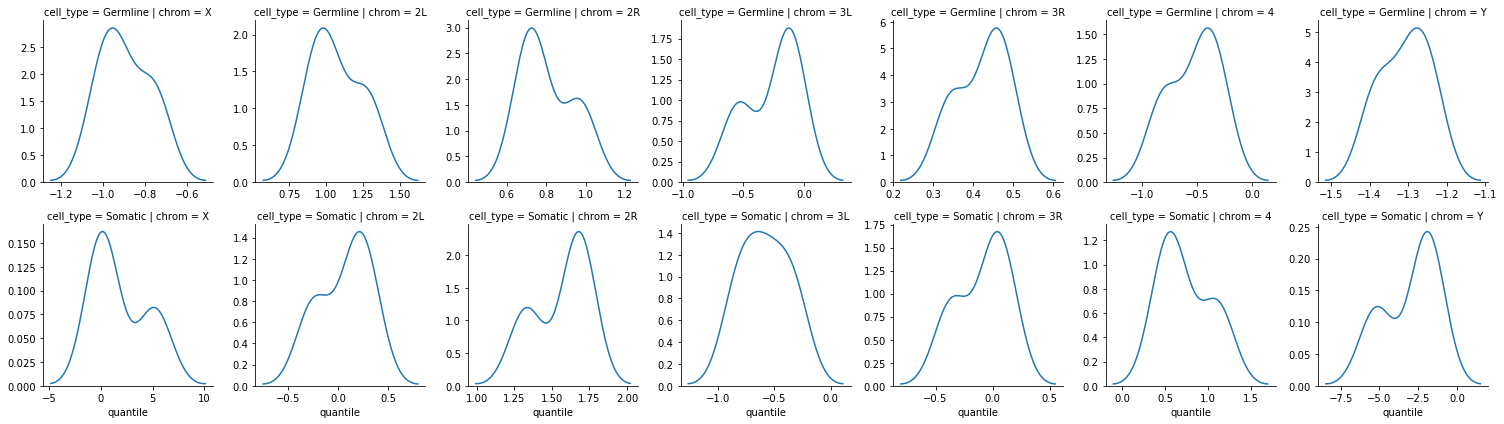

In [56]:
g = sns.FacetGrid(
    larval_sc, 
    col="chrom", 
    row="cell_type", 
    col_order="X,2L,2R,3L,3R,4,Y".split(","),
    row_order=["Germline", "Somatic"],
    sharex=False, 
    sharey=False
)
g.map(sns.kdeplot, "quantile")

In [57]:
formula = "quantile ~ C(cell_type)*C(chrom)"
model = ols(formula, larval_sc).fit()
summary = model.summary()
display(summary.tables[0])
summary.tables[2]

Dep. Variable:,quantile,R-squared:,0.705
Model:,OLS,Adj. R-squared:,0.569
Method:,Least Squares,F-statistic:,5.156
Date:,"Thu, 19 Dec 2019",Prob (F-statistic):,0.000138
Time:,18:18:25,Log-Likelihood:,-49.219
No. Observations:,42,AIC:,126.4
Df Residuals:,28,BIC:,150.8
Df Model:,13,,
Covariance Type:,nonrobust,,


Omnibus:,25.543,Durbin-Watson:,2.681
Prob(Omnibus):,0.000,Jarque-Bera (JB):,126.127
Skew:,1.061,Prob(JB):,4.09e-28
Kurtosis:,11.220,Cond. No.,20.6


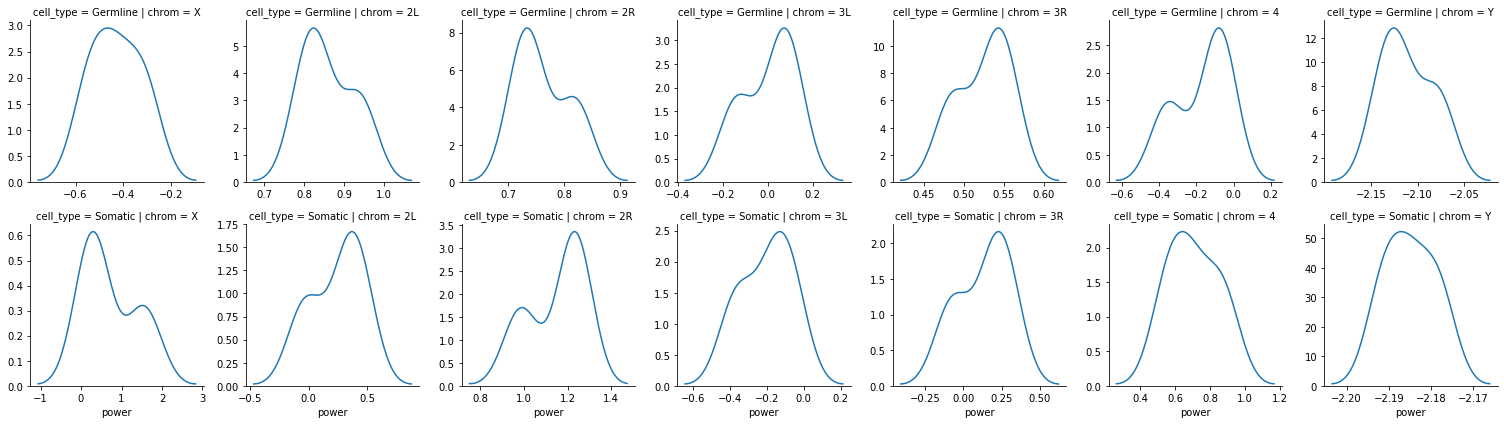

In [58]:
g = sns.FacetGrid(
    larval_sc, 
    col="chrom", 
    row="cell_type", 
    col_order="X,2L,2R,3L,3R,4,Y".split(","),
    row_order=["Germline", "Somatic"],
    sharex=False, 
    sharey=False
)
g.map(sns.kdeplot, "power")

In [59]:
formula = "power ~ C(cell_type)*C(chrom)"
model = ols(formula, larval_sc).fit()
summary = model.summary()
display(summary.tables[0])
summary.tables[2]

Dep. Variable:,power,R-squared:,0.963
Model:,OLS,Adj. R-squared:,0.946
Method:,Least Squares,F-statistic:,56.69
Date:,"Thu, 19 Dec 2019",Prob (F-statistic):,1.38e-16
Time:,18:18:27,Log-Likelihood:,9.8658
No. Observations:,42,AIC:,8.268
Df Residuals:,28,BIC:,32.60
Df Model:,13,,
Covariance Type:,nonrobust,,


Omnibus:,29.033,Durbin-Watson:,1.806
Prob(Omnibus):,0.000,Jarque-Bera (JB):,119.395
Skew:,1.407,Prob(JB):,1.19e-26
Kurtosis:,10.766,Cond. No.,20.6
